## Image classification with Quantized neural networks

In [1]:
# 최신 버전 설치(필요 시 주석 해제 후 실행)
# Colab은 런타임 CUDA 버전에 맞는 torch가 사전 설치되어 있는 경우가 많습니다.
# 아래 설치가 잘 안 맞는다면 주석 처리하고 넘어가세요.

# !pip -q install -U torch torchvision torchaudio
# 또는 CUDA 버전에 맞는 인덱스(URL)를 사용해야 할 수 있습니다.
# 예: CUDA 12.x Colab의 경우(변동 가능)
# !pip -q install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import sys, platform, torch, torchvision
print("Python:", sys.version)
print("Platform:", platform.platform())
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
Torch: 2.8.0+cu126
Torchvision: 0.23.0+cu126
CUDA available: True


현재 Python, OS, PyTorch/torchvision 버전, CUDA 사용 가능 여부를 출력해 실행 환경을 빠르게 점검합니다.

torch.cuda.is_available(): GPU(CUDA)를 사용할 수 있는지 즉시 확인.

In [2]:
import math
import os
import random
from dataclasses import dataclass
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # 연산 결정론 모드(재현성 ↑, 성능 ↓ 가능)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

학습에 필요한 라이브러리 임포트와 실험 재현성을 위한 시드 고정(seed) 설정.

seed_everything :

random, numpy, torch의 시드를 동일한 값으로 고정해 결과 변동을 줄입니다.

cudnn.deterministic=True, cudnn.benchmark=False로 연산을 결정론적으로 만듭니다(다만 성능이 조금 저하될 수 있음).

In [3]:
# Straight-Through Estimator(STE) 유틸
def ste_identity_like(x, quantized):
    # quantized는 forward에 쓰이고, backward는 x의 그래디언트가 그대로 흐르게 함
    return (quantized - x).detach() + x

def binarize_with_ste(x):
    # [-1, 1] 범위로 클리핑 후 sign 적용
    x_clamped = x.clamp(-1.0, 1.0)
    q = x_clamped.sign()
    # sign(0)=0이 되므로 0은 +1로 치우치지 않게 그대로 둠
    # STE로 gradient는 x를 따라가게 유지
    return ste_identity_like(x_clamped, q)

def quantize_kbits_symmetric_with_ste(x, k: int):
    """
    [-1, 1] 구간을 대상으로 균일 양자화.
    k비트이면 levels = 2^k.
    예: k=2 -> 4레벨
    """
    assert k >= 1
    x_clamped = x.clamp(-1.0, 1.0)
    levels = 2 ** k
    step = 2.0 / (levels - 1)  # [-1, 1]을 levels-1 등분
    # [-1,1] -> [0,2]로 쉬프트, step로 스케일, 반올림 -> 다시 복원
    q = torch.round((x_clamped + 1.0) / step) * step - 1.0
    return ste_identity_like(x_clamped, q)

def weight_binarize_with_channel_scaling(w: torch.Tensor, is_conv: bool):
    """
    XNOR-Net 스타일 스케일링:
    Conv: out_channel 단위로 평균 절대값 스케일 적용
    Linear: out_feature 단위로 스케일 적용
    """
    if is_conv:
        # (out_c, in_c, kH, kW) -> out_c별 평균 abs
        alpha = w.abs().mean(dim=(1, 2, 3), keepdim=True)
    else:
        # (out_f, in_f) -> out_f별 평균 abs
        alpha = w.abs().mean(dim=1, keepdim=True)
    wb = binarize_with_ste(w) * alpha
    return wb

### STE(Straight-Through Estimator) :

비미분 함수(sign, round 등)를 forward에서 쓰면서도 backward 때는 원래 값의 그래디언트를 흘려보내는 기법.

- ste_identity_like(x, quantized) :

forward: quantized(이진/양자화된 값) 사용

backward: (quantized - x).detach() + x로 구성해 x의 그래디언트를 그대로 유지

- binarize_with_ste(x) :

입력을 [-1, 1]로 클램프한 뒤 sign 적용해 {-1, 0, +1} 중 하나로 이진화
sign(0)=0이지만, STE 덕분에 미분은 원 신호를 따릅니다.

- quantize_kbits_symmetric_with_ste(x, k) :

[-1, 1] 구간에서 균일 k비트 양자화(레벨 수 = 2^k)
step 간격으로 반올림한 뒤 STE로 그래디언트는 원래 x를 따르게 만듭니다.

weight_binarize_with_channel_scaling(w, is_conv)

XNOR-Net 스타일 스케일링(https://arxiv.org/pdf/1603.05279) : 출력 채널(또는 출력 뉴런)별 평균 절대값(alpha)을 곱해 이진 가중치가 가진 스케일 손실을 보정.

Conv: (out_c, in_c, kH, kW) 기준으로 out_c별 평균, Linear: (out_f, in_f) 기준 out_f별 평균.

In [4]:
class BinaryActivation(nn.Module):
    def forward(self, x):
        # 배치정규화 뒤 or 중간 활성화로 사용 가정
        return binarize_with_ste(x)

class KbitActivation(nn.Module):
    def __init__(self, k: int):
        super().__init__()
        self.k = k
    def forward(self, x):
        return quantize_kbits_symmetric_with_ste(x, self.k)

class BinaryLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, last_layer_binary=False):
        super().__init__(in_features, out_features, bias=bias)
        self.last_layer_binary = last_layer_binary

    def forward(self, x):
        if self.last_layer_binary:
            w = weight_binarize_with_channel_scaling(self.weight, is_conv=False)
        else:
            # 마지막 레이어는 종종 full-precision 유지
            w = self.weight
        return F.linear(x, w, self.bias)

class BinaryConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, bias=True, last_layer_binary=False):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding,
                         dilation, groups, bias)
        self.last_layer_binary = last_layer_binary

    def forward(self, x):
        if self.last_layer_binary:
            w = weight_binarize_with_channel_scaling(self.weight, is_conv=True)
        else:
            w = self.weight
        return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

- BinaryActivation

forward에서 binarize_with_ste를 호출해 활성화를 이진화(W1).

- KbitActivation(k)

forward에서 quantize_kbits_symmetric_with_ste로 k비트 활성화(WA-k).

- BinaryLinear(nn.Linear)

last_layer_binary가 True이면 weight_binarize_with_channel_scaling으로 가중치를 이진화, False면 풀 프리시전 가중치 사용.

주의: 클래스 이름이 BinaryLinear지만, 실제 이진화 여부는 last_layer_binary 플래그로 제어합니다(모델에서 내부 레이어는 True, 마지막 레이어는 선택).

- BinaryConv2d(nn.Conv2d)

Conv 버전. 동작 원리는 BinaryLinear와 동일(채널별 스케일링 포함).

In [5]:
class BNN_MNIST_FC(nn.Module):
    """
    MNIST용 간단한 이진화 완전연결 네트워크
    - W1A1: BinaryActivation 사용
    - W1A2: KbitActivation(k=2) 사용
    마지막 Linear는 full-precision로 두어 성능 보정(옵션)
    """
    def __init__(self, hidden=1024, activation_bits=1, last_layer_binary=False):
        super().__init__()
        if activation_bits == 1:
            act = BinaryActivation()
        else:
            act = KbitActivation(k=activation_bits)

        self.flatten = nn.Flatten()
        self.fc1 = BinaryLinear(28*28, hidden, bias=False, last_layer_binary=True)  # 내부 가중치는 이진화
        self.bn1 = nn.BatchNorm1d(hidden)
        self.act1 = act

        self.fc2 = BinaryLinear(hidden, hidden, bias=False, last_layer_binary=True)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.act2 = act

        self.fc3 = BinaryLinear(hidden, 10, bias=True, last_layer_binary=last_layer_binary)
        # 출력 직전에는 보통 활성화를 두지 않음 (로짓)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.fc3(x)
        return x

### BNN_MNIST_FC
구조: Flatten → [FC1 + BN + Act] → [FC2 + BN + Act] → FC3(로짓)

activation_bits=1이면 BinaryActivation(W1A1), 2면 2비트 활성화(W1A2)
fc1, fc2는 last_layer_binary=True로 설정(즉, 가중치 이진화 사용)

fc3는 last_layer_binary=모델 인자에 따름(기본 False: 마지막 레이어는 풀 프리시전 유지해 성능 보정)

배치정규화(BN) 후에 이진/양자화 활성화를 두어 값의 분포를 안정화시키고 정보 손실을 줄입니다.

In [6]:
BATCH_SIZE = 128
NUM_WORKERS = 2 if os.name != "nt" else 0

transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
    transforms.Normalize((0.1307,), (0.3081,)),  # MNIST 표준 정규화
])

train_ds = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_ds  = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


(60000, 10000)

변환(transforms)

- ToTensor(): [0,1] 범위의 텐서로 변환

- Normalize(mean=0.1307, std=0.3081): MNIST 표준화

- DataLoader

batch_size=128, shuffle=True(학습), False(테스트)

- num_workers: 병렬 로딩 워커 수. Windows에서는 0 권장.

- pin_memory=True: CUDA로 텐서 복사 속도를 개선.

train_ds/test_ds는 torchvision.datasets.MNIST로 자동 다운로드 가능.

In [7]:
@dataclass
class TrainConfig:
    epochs: int = 3          # 빠른 실습 기본값
    lr: float = 1e-3
    weight_decay: float = 0.0
    activation_bits: int = 1 # 1: W1A1, 2: W1A2
    last_layer_binary: bool = False

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    for images, labels in tqdm(loader, leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_acc  += accuracy(logits.detach(), labels) * images.size(0)

    total_loss /= len(loader.dataset)
    total_acc  /= len(loader.dataset)
    return total_loss, total_acc

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    for images, labels in tqdm(loader, leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        total_loss += loss.item() * images.size(0)
        total_acc  += accuracy(logits, labels) * images.size(0)
    total_loss /= len(loader.dataset)
    total_acc  /= len(loader.dataset)
    return total_loss, total_acc

- TrainConfig(dataclass)

epochs, lr, weight_decay, activation_bits, last_layer_binary 등을 한 곳에서 관리.

- accuracy(logits, targets)

argmax로 예측 라벨을 구해 정확도 계산.

- train_one_epoch(model, loader, optimizer, scaler=None)

model.train()으로 학습 모드

배치 순회: forward → CE loss → backward → optimizer.step()

손실/정확도를 샘플 수 기준으로 누적해 에폭 평균 반환

참고: scaler는 혼합정밀(AMP)용 자리지만 본 예제에서는 사용하지 않음

- evaluate(model, loader)

@torch.no_grad()로 평가 시 그래디언트 비활성화

model.eval()로 드롭아웃/BN 등 평가 모드

손실/정확도 계산 후 평균 반환

In [8]:
cfg = TrainConfig(
    epochs=3,            # Colab에서 10~20으로 늘리면 성능 더 올라갑니다.
    lr=1e-3,
    weight_decay=0.0,
    activation_bits=1,   # 1 -> W1A1, 2 -> W1A2
    last_layer_binary=False
)

model = BNN_MNIST_FC(
    hidden=1024,
    activation_bits=cfg.activation_bits,
    last_layer_binary=cfg.last_layer_binary
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

print(model)
best_acc = 0.0
for epoch in range(1, cfg.epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc = evaluate(model, test_loader)
    best_acc = max(best_acc, val_acc)
    print(f"[Epoch {epoch:02d}] Train Loss {train_loss:.4f} | Train Acc {train_acc*100:.2f}% "
          f"| Test Loss {val_loss:.4f} | Test Acc {val_acc*100:.2f}%")

print("Best Test Acc:", f"{best_acc*100:.2f}%")

BNN_MNIST_FC(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): BinaryLinear(in_features=784, out_features=1024, bias=False)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): BinaryActivation()
  (fc2): BinaryLinear(in_features=1024, out_features=1024, bias=False)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): BinaryActivation()
  (fc3): BinaryLinear(in_features=1024, out_features=10, bias=True)
)


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    if w.is_alive():self._shutdown_workers()
 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive(): 
    ^ ^ ^ ^ ^ ^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^^ ^  ^^ 
   File "/usr/lib/p

[Epoch 01] Train Loss 0.2365 | Train Acc 92.92% | Test Loss 0.1614 | Test Acc 95.22%


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch 02] Train Loss 0.1211 | Train Acc 96.28% | Test Loss 0.1121 | Test Acc 96.63%


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch 03] Train Loss 0.0921 | Train Acc 97.15% | Test Loss 0.1132 | Test Acc 96.49%
Best Test Acc: 96.63%


- cfg = TrainConfig(...)

기본은 epochs=3, lr=1e-3, activation_bits=1(W1A1), 마지막 레이어는 풀 프리시전(성능 안정)

- model = BNN_MNIST_FC(...)

hidden=1024로 충분히 큰 용량을 확보(이진화로 인한 표현력 감소를 보완)
optimizer = Adam

이진/양자화 네트워크에도 안정적으로 동작하는 옵티마이저 선택

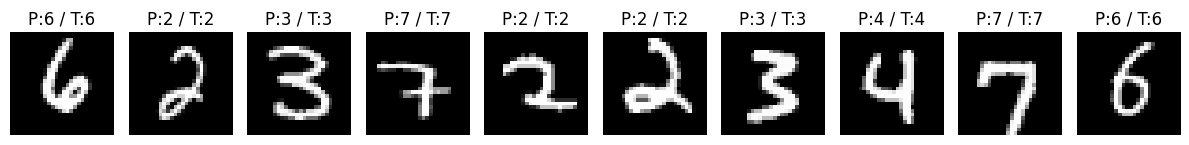

In [9]:
@torch.no_grad()
def show_predictions(model, dataset, n=8):
    model.eval()
    idxs = np.random.choice(len(dataset), size=n, replace=False)
    images = torch.stack([dataset[i][0] for i in idxs], dim=0).to(device)
    labels = torch.tensor([dataset[i][1] for i in idxs], device=device)
    logits = model(images)
    preds = logits.argmax(dim=1)

    images_np = images.cpu().numpy()
    # 정규화를 역정규화해서 보여주기
    mean, std = 0.1307, 0.3081
    imgs_vis = images_np * std + mean

    plt.figure(figsize=(12, 2.5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(imgs_vis[i, 0], cmap="gray")
        plt.title(f"P:{preds[i].item()} / T:{labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(model, test_ds, n=10)

- show_predictions(model, dataset, n=8)

무작위 n개 샘플 뽑아 모델 예측 수행

이미지 시각화 전, MNIST 표준화(정규화)를 역정규화(mean/std 복원)하여 사람이 보기 좋게 표시

각 subplot 제목에 P: 예측, T: 정답을 함께 표시

In [11]:
import json
import pickle
import torch

save_path = "bnn_mnist_fc.pt"

def load_checkpoint_with_fallback(path: str):
    """
    1) 기본(weights_only=True) 로드 시도
    2) 실패 시 safe_globals에 TorchVersion allowlist 추가 후 재시도
    3) 그래도 안 되면 weights_only=False로 레거시 방식 로드 (신뢰된 파일일 때만)
    """
    try:
        # PyTorch 2.6+ 기본: weights_only=True
        ckpt = torch.load(path, map_location="cpu")
        how = "weights_only=True (default)"
        return ckpt, how
    except pickle.UnpicklingError:
        try:
            import torch.serialization as ts
            # 안전 목록에 TorchVersion 허용
            ts.add_safe_globals([torch.torch_version.TorchVersion])
            ckpt = torch.load(path, map_location="cpu")
            how = "weights_only=True with safe_globals"
            return ckpt, how
        except Exception:
            # 신뢰된 체크포인트일 때만 사용하세요(任意 코드 실행 위험)
            ckpt = torch.load(path, map_location="cpu", weights_only=False)
            how = "weights_only=False (legacy fallback; trusted file only)"
            return ckpt, how
    except Exception:
        # 기타 예외도 최종 fallback 시도
        ckpt = torch.load(path, map_location="cpu", weights_only=False)
        how = "weights_only=False (fallback; trusted file only)"
        return ckpt, how

# 1) 기존 체크포인트 로드
ckpt, how_loaded = load_checkpoint_with_fallback(save_path)
print(f"Checkpoint loaded via: {how_loaded}")

# 2) 모델 복원 및 평가
loaded_cfg = TrainConfig(**ckpt["cfg"])
loaded_model = BNN_MNIST_FC(
    hidden=1024,
    activation_bits=loaded_cfg.activation_bits,
    last_layer_binary=loaded_cfg.last_layer_binary
).to(device)
loaded_model.load_state_dict(ckpt["state_dict"])

test_loss, test_acc = evaluate(loaded_model, test_loader)
print(f"Reloaded model evaluated. Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

# 3) 앞으로 안전하게 쓰기 위한 포맷으로 재저장(가중치만 + JSON 설정)
safe_weights_path = "bnn_mnist_fc-weights.pth"   # state_dict만 저장
safe_config_path  = "bnn_mnist_fc-config.json"   # cfg를 JSON으로 저장

torch.save(ckpt["state_dict"], safe_weights_path)  # weights_only 형식
with open(safe_config_path, "w") as f:
    json.dump(ckpt["cfg"], f)

print(f"Re-saved safe files:\n- {safe_weights_path}\n- {safe_config_path}")

Checkpoint loaded via: weights_only=True with safe_globals


  0%|          | 0/79 [00:00<?, ?it/s]

Reloaded model evaluated. Test Loss: 0.1132 | Test Acc: 96.49%
Re-saved safe files:
- bnn_mnist_fc-weights.pth
- bnn_mnist_fc-config.json


체크포인트 저장/로딩

In [12]:
# 안전 포맷 로드 예시(참고):
# state = torch.load(safe_weights_path, map_location=device, weights_only=True)
# with open(safe_config_path) as f:
#     cfg_dict = json.load(f)
# model = BNN_MNIST_FC(hidden=1024, activation_bits=cfg_dict['activation_bits'],
#                      last_layer_binary=cfg_dict['last_layer_binary']).to(device)
# model.load_state_dict(state)

<All keys matched successfully>

In [13]:
cfg_w1a2 = TrainConfig(
    epochs=3,
    lr=1e-3,
    activation_bits=2,     # 2비트 활성화
    last_layer_binary=False
)

model_w1a2 = BNN_MNIST_FC(hidden=1024, activation_bits=cfg_w1a2.activation_bits,
                          last_layer_binary=cfg_w1a2.last_layer_binary).to(device)
optimizer_w1a2 = torch.optim.Adam(model_w1a2.parameters(), lr=cfg_w1a2.lr)

for epoch in range(1, cfg_w1a2.epochs + 1):
    train_loss, train_acc = train_one_epoch(model_w1a2, train_loader, optimizer_w1a2)
    val_loss, val_acc = evaluate(model_w1a2, test_loader)
    print(f"[W1A2][Epoch {epoch:02d}] Train Loss {train_loss:.4f} | Train Acc {train_acc*100:.2f}% "
          f"| Test Loss {val_loss:.4f} | Test Acc {val_acc*100:.2f}%")

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():
       self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): ^
^  ^  ^ ^ ^ ^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ 
  File "/usr/lib/pyth

[W1A2][Epoch 01] Train Loss 0.2500 | Train Acc 92.50% | Test Loss 0.1544 | Test Acc 95.44%


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>   ^^^^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
if w.is_alive():     assert self._parent_pid == os.getpid(), 'can only test a child process'  
        ^  ^ ^^ ^^ ^^ ^ ^^^^^^^^
  File 

  0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

       if w.is_alive():  
    ^^ ^ ^  ^^^ ^^^^^^^^^^^^^^
^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

[W1A2][Epoch 02] Train Loss 0.1310 | Train Acc 96.00% | Test Loss 0.1147 | Test Acc 96.41%


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>
<function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
          if w.is_alive():
  ^ ^^  ^^^   ^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

  0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>
<function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>self._shutdown_workers()Exception ignored in: 


  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78caaffaeb60>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/ut

[W1A2][Epoch 03] Train Loss 0.0958 | Train Acc 96.97% | Test Loss 0.1112 | Test Acc 96.64%


W1A2(2비트 활성화)로 전환해 보기(옵션)

cfg_w1a2에서 activation_bits=2로 변경

이진 활성화(W1A1)보다 값 표현력이 늘어 일반적으로 수렴이 안정적일 수 있음

동일한 구조/루프로 간단 비교 실험 가능

epochs를 더 늘리면 차이를 더 명확히 볼 수 있습니다.


마지막 레이어 풀 프리시전 유지

BNN에서 마지막 레이어는 종종 풀 프리시전이 성능에 유리합니다(분류 경계의 세밀함 보존).

스케일링(alpha)

가중치 이진화 시 채널별 평균 절대값을 곱해 스케일 손실을 보정하는 것은 XNOR-Net의 핵심 아이디어 중 하나입니다.

학습 안정화

BatchNorm 후 활성화 양자화는 값의 분산을 안정화해 학습에 도움을 줍니다.

성능 개선 아이디어

더 많은 epoch, 학습률 스케줄러(CosineAnnealingWarmRestarts 등), 데이터 증강

완전연결(FC) → 합성곱(Conv) BNN으로 확장하면 이미지 과제에서 성능 향상 가능